In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

Global seed set to 0


# Read data from scvelo package

In [2]:
adata = scv.datasets.bonemarrow()

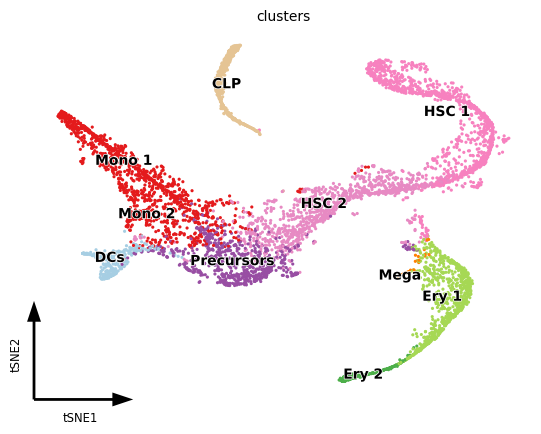

In [3]:
scv.pl.tsne(adata, color='clusters', frameon='artist')

# Setup data and train model

In [4]:
scv.pp.filter_genes(adata, min_shared_counts=20)
adata = ltv.utils.standard_clean_recipe(adata)

Filtered out 7837 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
model = ltv.models.VAE(observed=2000, latent_dim=20, zr_dim=2, h_dim=2)

In [6]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                      epochs=50, name='bonemarrow_parameters', grad_clip=100)

Warning, folder already exists. This may overwrite a previous fit.
494 velocity genes used
epoch 0, full loss 143.815, val loss 90.243, recon MSE 4.465, traj MSE 0.412, reg loss -2.922
epoch 1, full loss 49.015, val loss -22.005, recon MSE 3.334, traj MSE 0.393, reg loss -3.628
epoch 2, full loss 24.169, val loss -134.202, recon MSE 1.829, traj MSE 0.351, reg loss -2.611
epoch 3, full loss 93.312, val loss -242.155, recon MSE 1.499, traj MSE 0.323, reg loss -1.471
epoch 4, full loss 167.648, val loss -323.832, recon MSE 1.351, traj MSE 0.326, reg loss -1.049
epoch 5, full loss 256.001, val loss -377.463, recon MSE 1.285, traj MSE 0.330, reg loss -0.474
epoch 6, full loss 364.836, val loss -412.077, recon MSE 1.221, traj MSE 0.317, reg loss -0.517
epoch 7, full loss 433.652, val loss -431.871, recon MSE 1.195, traj MSE 0.299, reg loss -0.378
epoch 8, full loss 511.165, val loss -444.645, recon MSE 1.160, traj MSE 0.298, reg loss -0.300
epoch 9, full loss 537.333, val loss -452.826, reco

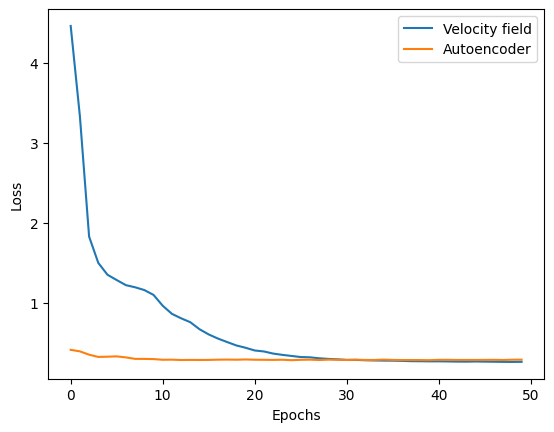

In [7]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

# Compute and plot velocity on tSNE

In [8]:
latent_adata, adta = ltv.output_results(model, adata, gene_velocity=True,embedding='tsne')

In [9]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)


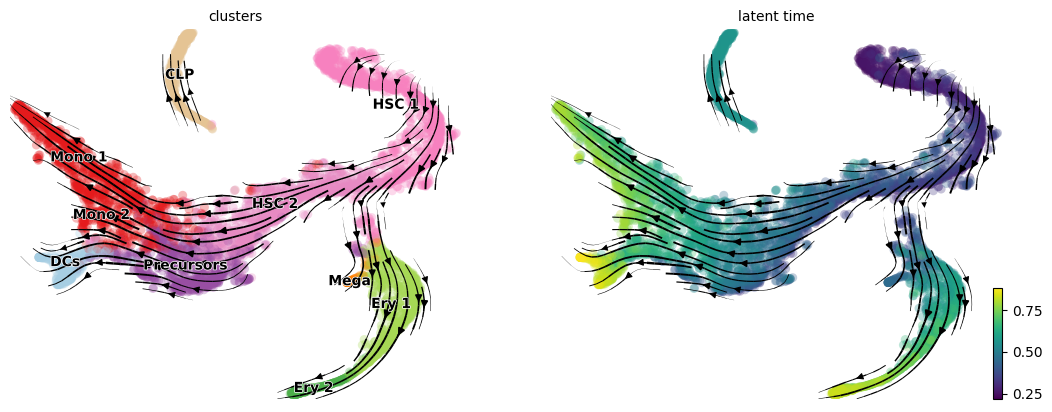

In [10]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity',
                                color=['clusters', 'latent_time'])

saving figure to file ../figures/bonemarrow_model_tsne.png


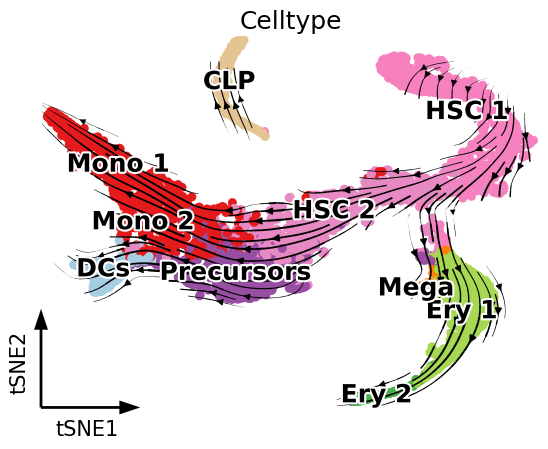

In [11]:
scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', color=['clusters'], 
                                 title='Celltype', alpha=1, 
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=18, frameon='artist',
                                save='../figures/bonemarrow_model_tsne.png')

saving figure to file ../figures/bonemarrow_model_tsne_lineages.png


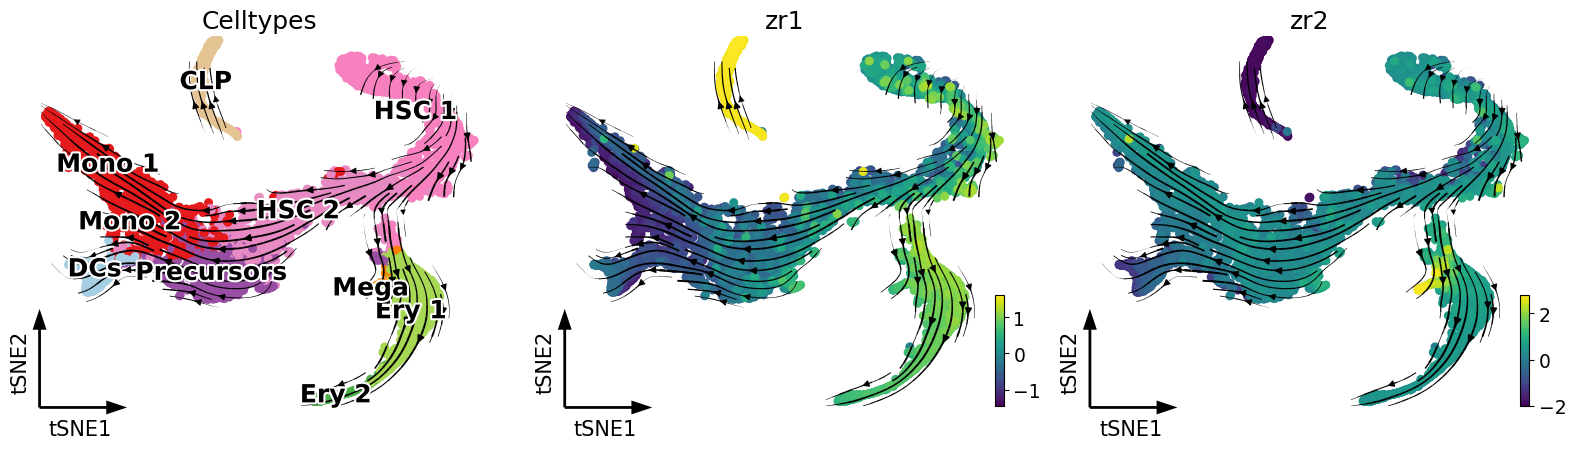

In [12]:
latent_adata.obs['zr1'] = latent_adata.obsm['zr'][:,0]
latent_adata.obs['zr2'] = latent_adata.obsm['zr'][:,1]
scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', color=['clusters', 'zr1', 'zr2'], 
                                 title=['Celltypes', 'zr1', 'zr2'], alpha=1, 
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=18, frameon='artist',
                                save='../figures/bonemarrow_model_tsne_lineages.png')

saving figure to file ../figures/bonemarrow_model_tsne_novelo.png


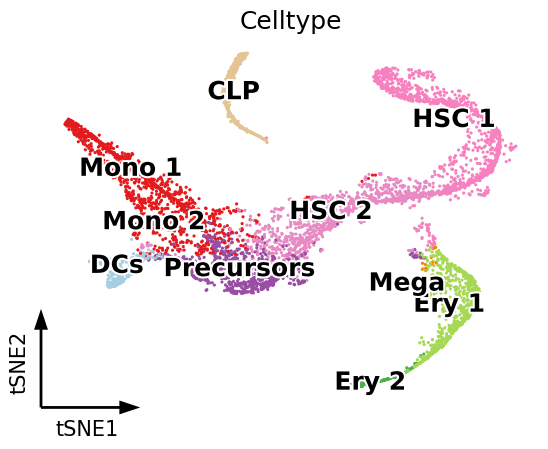

saving figure to file ../figures/bonemarrow_model_tsne_latent_time.png


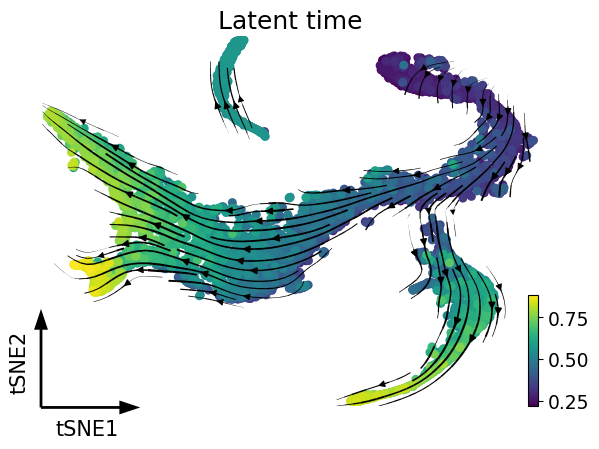

In [13]:
scv.pl.tsne(latent_adata,vkey='spliced_velocity', color=['clusters'], 
                                 title='Celltype', alpha=1, 
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=18, frameon='artist',
                                save='../figures/bonemarrow_model_tsne_novelo.png')

scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', basis='tsne', color=['latent_time'], 
                                 title='Latent time', alpha=1, 
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=18, frameon='artist',
                                save='../figures/bonemarrow_model_tsne_latent_time.png')

In [14]:
# save fit
latent_adata.write('../benchmark/real_data/fits/bonemarrow_latent_adata.h5ad')

# Compute CBDir transition scores

In [15]:
bonemarrow_edges = [
    ('HSC_1', 'Mega'),
    ('HSC_1', 'CLP'),
    ('HSC_1', 'Ery_1'), 
    ('Ery_1', 'Ery_2'),
    ('HSC_1', 'HSC_2'),
    ('HSC_2','Precursors'),
    ('HSC_2', 'Mono_2'),
    ('Mono_2', 'Mono_1'),
    ('Precursors','DCs')]

In [16]:
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
bonemarrow_pca = ltv.ev.cross_boundary_correctness(latent_adata,
                                  'clusters', 'spliced_velocity_pca', bonemarrow_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:02) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


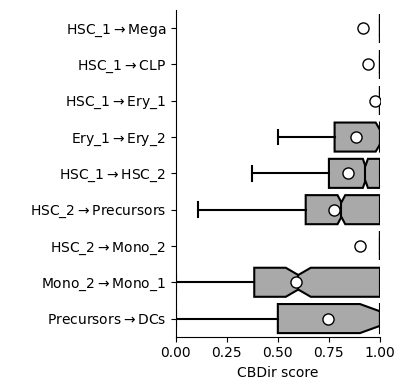

In [17]:
ax=ltv.pl.transition_scores(bonemarrow_pca, raw=True)
ax.set(xlim=(0,1))
plt.show()

# Plot z_r scatter and compute lineage classification accuracy from z_r

Renamed 'zr' to convention 'X_zr' (adata.obsm).
saving figure to file ../figures/bonemarrow_zr.png


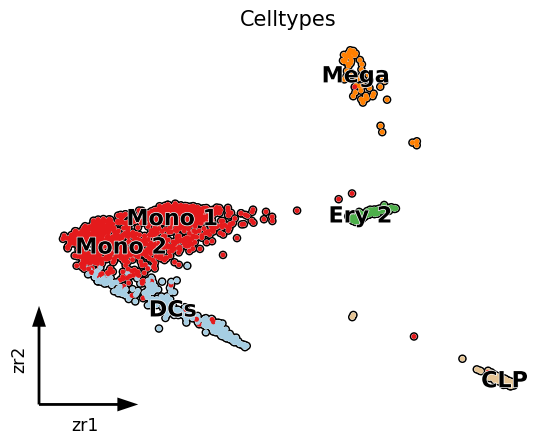

In [18]:
scv.pl.scatter(latent_adata[latent_adata.obs.clusters.isin(['Mega', 'Ery_2', 'Mono_1','Mono_2', 'DCs','CLP'])],
               'zr', color='clusters', frameon='artist', title='Celltypes', fontsize=15,
              legend_fontsize=16, add_outline=True,
              save = '../figures/bonemarrow_zr.png')

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

clf = LogisticRegression(penalty='none', max_iter=1e4)

data_= latent_adata[latent_adata.obs['clusters'].isin(['Mega', 'Ery_2', 'Mono_1', 'DCs','CLP'])].copy()

X = data_.obsm['zr']
y = LabelEncoder().fit_transform(data_.obs['clusters'].values)


pancreas_cvs = cross_val_score(clf, X, y, cv=25)

In [20]:
print('Prediction accuracy (2.5, 50, 97.5) percentiles:', np.percentile(pancreas_cvs, q=[2.5,50,97.5]))

Prediction accuracy (2.5, 50, 97.5) percentiles: [0.95405405 0.98630137 1.        ]


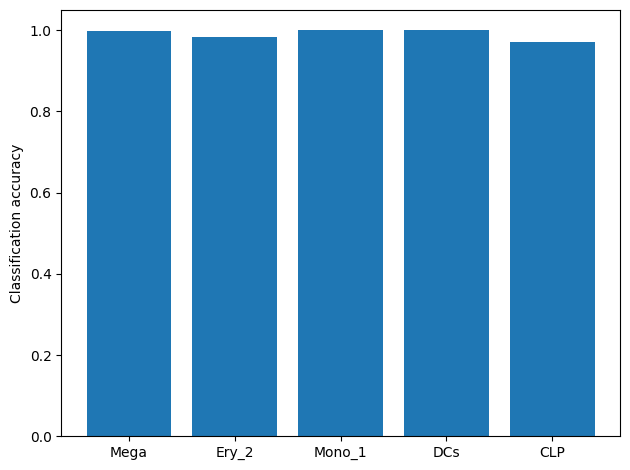

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
clf.fit(X, y)
pred = clf.predict(X)
class_accuracy = confusion_matrix(y, pred, normalize="true").diagonal()

fig, ax = plt.subplots()

plt.bar(x=['Mega', 'Ery_2', 'Mono_1', 'DCs','CLP'],height=class_accuracy)

ax.set(ylim=(0,1.05))
ax.set(ylabel='Classification accuracy')
plt.tight_layout()
plt.show()

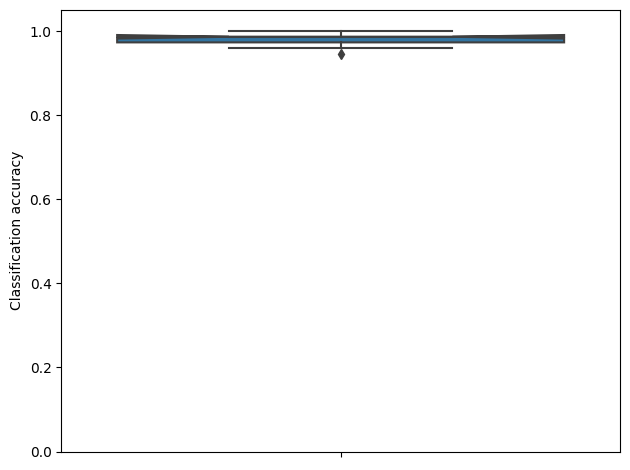

In [22]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

sns.boxplot(y=pancreas_cvs, ax=ax, notch=True)

ax.set(ylim=(0,1.05))
ax.set(ylabel='Classification accuracy')
plt.tight_layout()
plt.show()

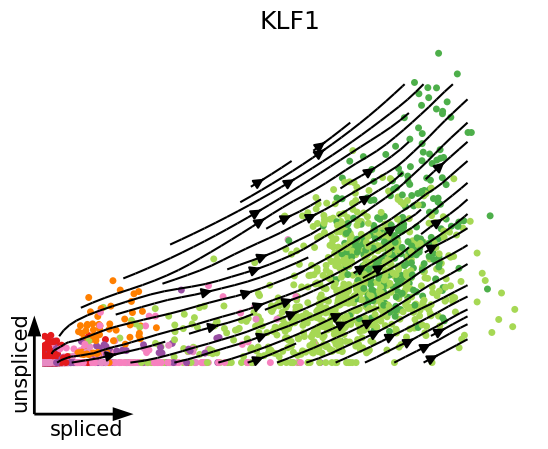

In [23]:
ltv.pl.scatter_stream(adata, 'KLF1', cluster_key='clusters', min_density=0.1)

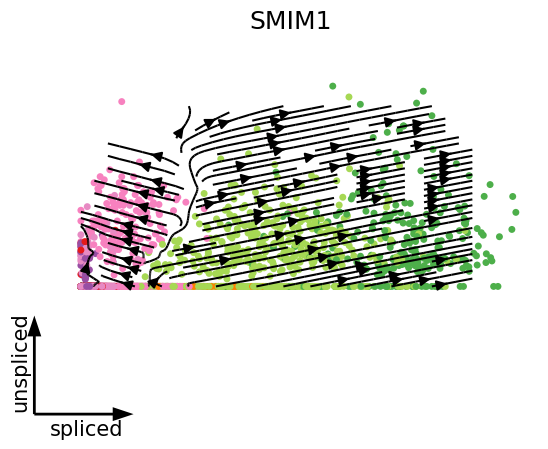

In [24]:
ltv.pl.scatter_stream(adata, 'SMIM1', cluster_key='clusters')

# Cell trajectories

In [25]:
z_traj, times = ltv.cell_trajectories(model, adata)

In [26]:
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
umap = UMAP(n_components=2, min_dist=1, random_state=12).fit(latent_adata.X) #random_state=18 # 8

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap_latent', embedded velocity vectors (adata.obsm)


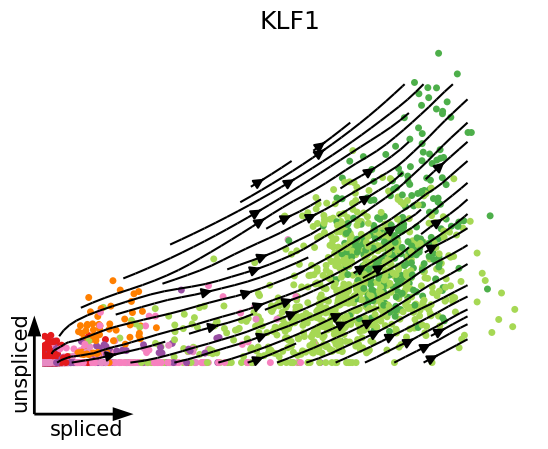

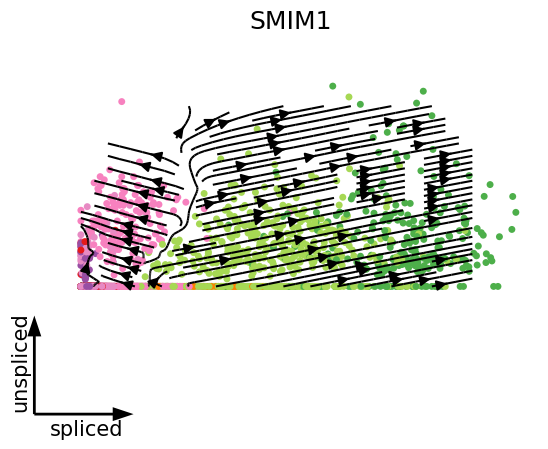

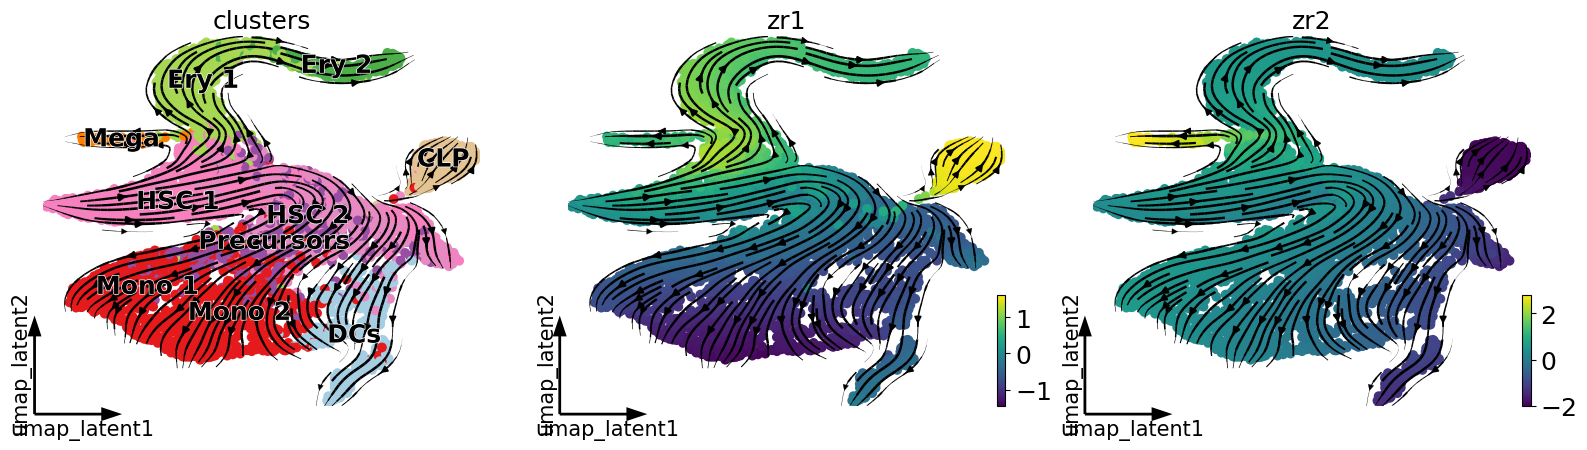

In [27]:
latent_adata.obsm['X_umap_latent'] = umap.transform(latent_adata.X)
latent_adata.obs['zr1'] = latent_adata.obsm['zr'][:,0]
latent_adata.obs['zr2'] = latent_adata.obsm['zr'][:,1]
scv.pp.neighbors(latent_adata, use_rep='X', n_neighbors=30)
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 basis='umap_latent', color=['clusters','zr1', 'zr2'], alpha=1, size=200,
                                frameon='artist', cutoff_perc=0)

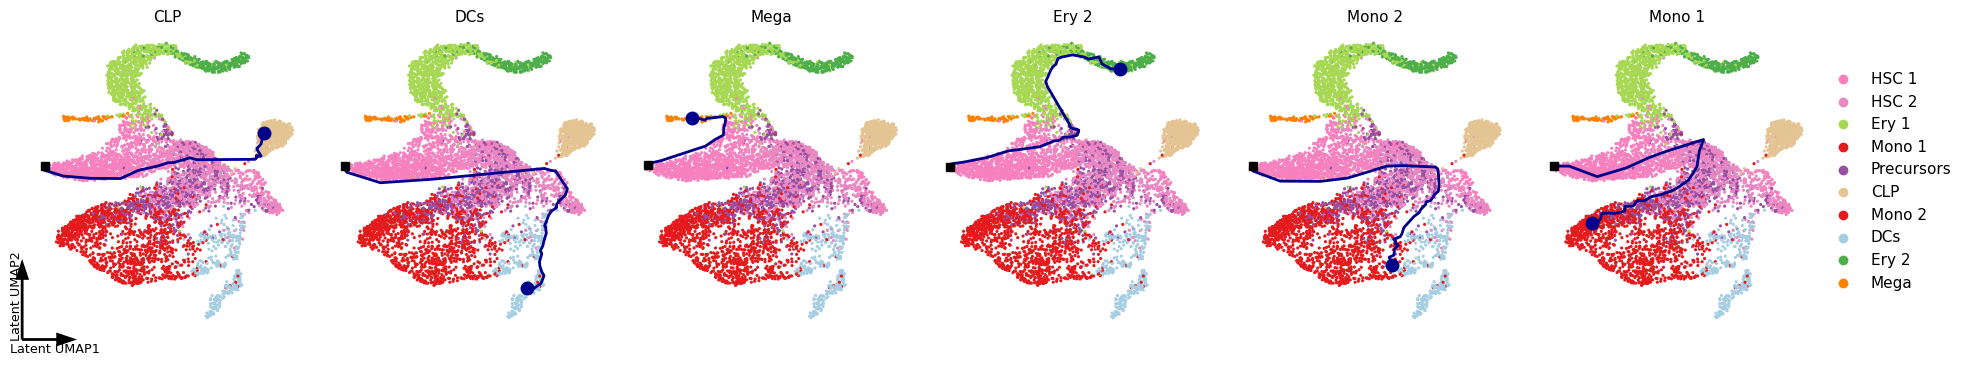

In [28]:
cells = [723, 212, 193, 5330, 3159, 5433]

from sklearn.inspection import DecisionBoundaryDisplay
color = '#00008B'

import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['#1f78b4', '#b2df8a', '#6a3d9a', '#cab2d6'])


fig,ax=plt.subplots(1, 6, figsize=(20,4))
ax=ax.flatten()


color = '#00008B'

latent_adata.obsm['X_umap'] = latent_adata.obsm['X_umap_latent']

z_traj_pca = umap.transform(z_traj[cells[0],times[cells[0],:,0]<=latent_adata.obs['latent_time'][cells[0]],:20].detach().cpu().numpy())
ax[0].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[0].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[0].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[0], color='clusters', frameon='artist',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=11, title='CLP', legend_loc='none')



z_traj_pca = umap.transform(z_traj[cells[1],times[cells[1],:,0]<=latent_adata.obs['latent_time'][cells[1]],:20].detach().cpu().numpy())
ax[1].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[1].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[1].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[1], color='clusters',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=11, title='DCs', legend_loc='none')


z_traj_pca = umap.transform(z_traj[cells[2],times[cells[2],:,0]<=latent_adata.obs['latent_time'][cells[2]],:20].detach().cpu().numpy())
ax[2].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[2].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[2].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[2], color='clusters',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', fontsize=11, show=False, title='Mega', legend_loc='none')


z_traj_pca = umap.transform(z_traj[cells[3],times[cells[3],:,0]<=latent_adata.obs['latent_time'][cells[3]],:20].detach().cpu().numpy())
ax[3].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[3].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[3].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[3], color='clusters',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=11, title='Ery 2', legend_loc='none')



z_traj_pca = umap.transform(z_traj[cells[4],times[cells[4],:,0]<=latent_adata.obs['latent_time'][cells[4]],:20].detach().cpu().numpy())
ax[4].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[4].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[4].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[4], color='clusters',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=11, title='Mono 2', legend_loc='none')


z_traj_pca = umap.transform(z_traj[cells[5],times[cells[5],:,0]<=latent_adata.obs['latent_time'][cells[5]],:20].detach().cpu().numpy())
ax[5].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[5].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[5].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[5], color='clusters',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=11, title='Mono 1', 
            legend_loc='right', legend_fontsize=11)

plt.tight_layout()
plt.savefig('../figures/bonemarrow_trajectories.png', dpi=500)
plt.show()